In [1]:

import tensorflow as tf
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2023-12-07 21:14:14.067571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 21:14:14.067590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 21:14:14.068295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 21:14:14.072447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 21:14:14.675610: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt

# create empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])
        

In [3]:
X_RES = 80
Y_RES = 80

In [4]:
def build_model (train_model=False):
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    model = keras.Sequential()
    
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', input_shape=(Y_RES, X_RES, 3), padding='valid'))
    model.add(MaxPooling2D(2, 2))   
    if train_model:
        model.add(Dropout(0.4))
    

    model.add(Conv2D(320, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))
    

    model.add(Conv2D(480, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))
    
    
    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model


In [5]:

model = build_model(train_model=True)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 39, 39, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 320)       368960    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 320)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 320)       0

2023-12-07 21:14:15.737951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 21:14:15.762343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 21:14:15.762477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
train_dir = 'data/ff_manual_annotate/train'

# Define the label values for each directory
label_values = {'Drowsy': 1, 'NonDrowsy': 0}

batch_size = 16

train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
            rotation_range=5,  # Rotate images by up to 20 degrees
            width_shift_range=0.2,  # Shift the width of the image by up to 20%
            height_shift_range=0.2,  # Shift the height of the image by up to 20%
            shear_range=0.2,  # Apply shear transformation
            zoom_range=0.2,  # Zoom in by up to 20%
            horizontal_flip=False,  # Flip images horizontally
            fill_mode='nearest',  # Fill in missing pixels with the nearest value
            validation_split=0.3
        )



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(label_values.keys()),  # Use the label values as class names

)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    classes=list(label_values.keys()),  # Use the label values as class names

)


Found 260 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


Epoch 1/100


2023-12-07 21:14:22.650354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-07 21:14:22.794390: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-07 21:14:22.873422: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 21:14:23.114275: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 21:14:23.645230: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8eecbece50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 21:14:23.645248: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

14/16 [=========================>....] - ETA: 0s - loss: 0.8741 - accuracy: 0.5189

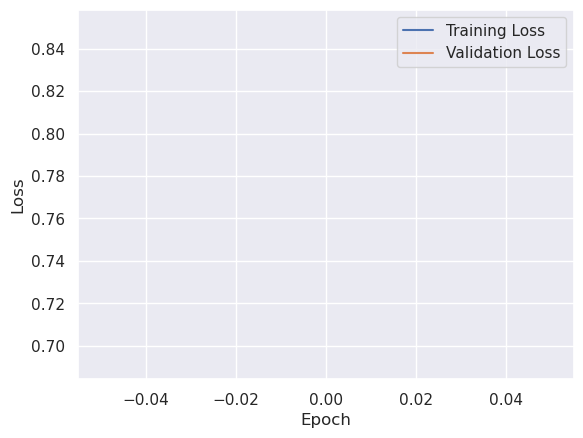

16/16 [==============================] - 5s 93ms/step - loss: 0.8505 - accuracy: 0.5164 - val_loss: 0.6921 - val_accuracy: 0.5417
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6918 - accuracy: 0.5482

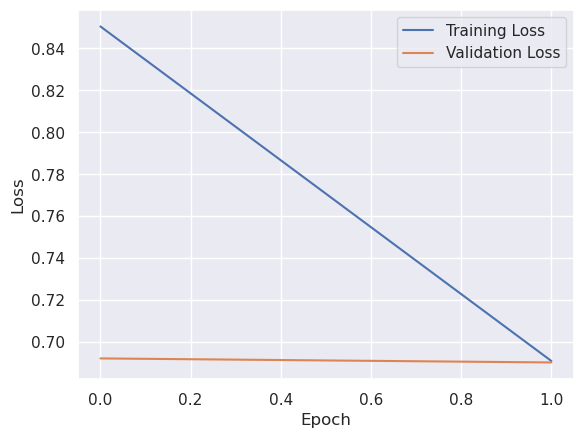

16/16 [==============================] - 1s 66ms/step - loss: 0.6909 - accuracy: 0.5574 - val_loss: 0.6902 - val_accuracy: 0.5417
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5697

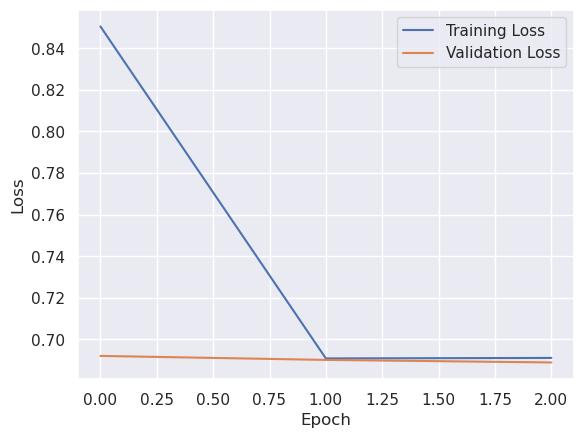

16/16 [==============================] - 1s 65ms/step - loss: 0.6911 - accuracy: 0.5697 - val_loss: 0.6889 - val_accuracy: 0.5625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5615

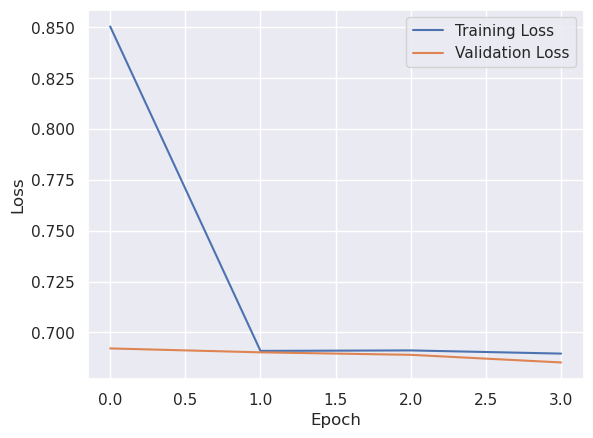

16/16 [==============================] - 1s 66ms/step - loss: 0.6895 - accuracy: 0.5615 - val_loss: 0.6852 - val_accuracy: 0.5625
Epoch 5/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6755 - accuracy: 0.5395

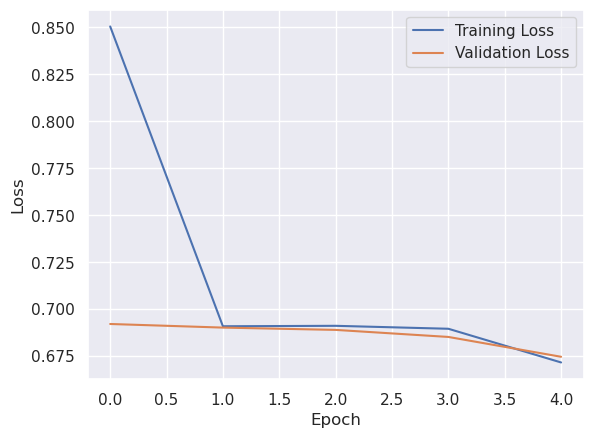

16/16 [==============================] - 1s 72ms/step - loss: 0.6716 - accuracy: 0.5492 - val_loss: 0.6746 - val_accuracy: 0.5729
Epoch 6/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6779 - accuracy: 0.5614

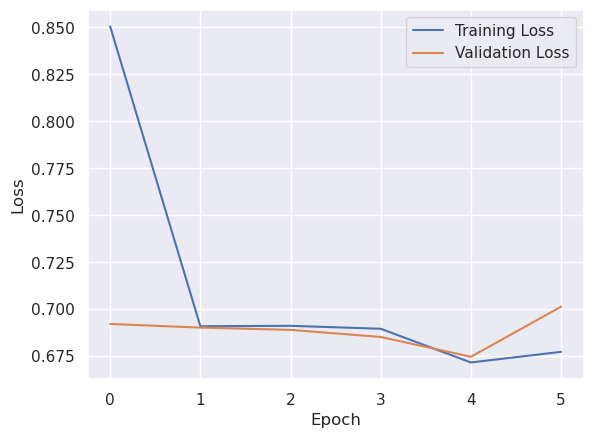

16/16 [==============================] - 1s 66ms/step - loss: 0.6773 - accuracy: 0.5533 - val_loss: 0.7013 - val_accuracy: 0.5521
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5615

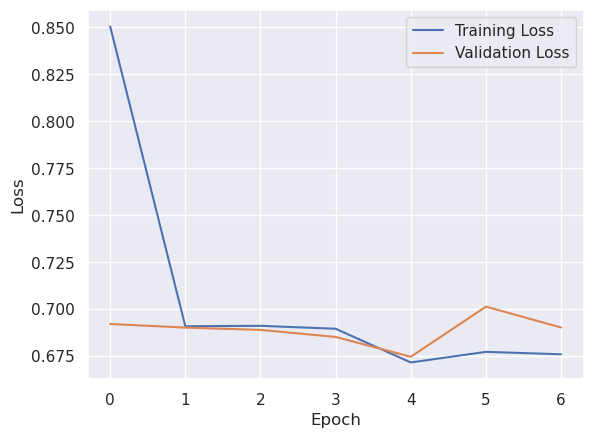

16/16 [==============================] - 1s 64ms/step - loss: 0.6760 - accuracy: 0.5615 - val_loss: 0.6902 - val_accuracy: 0.5729
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5738

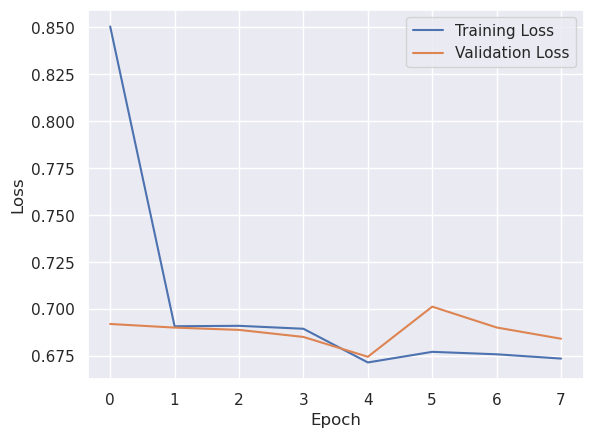

16/16 [==============================] - 1s 63ms/step - loss: 0.6737 - accuracy: 0.5738 - val_loss: 0.6842 - val_accuracy: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.5738

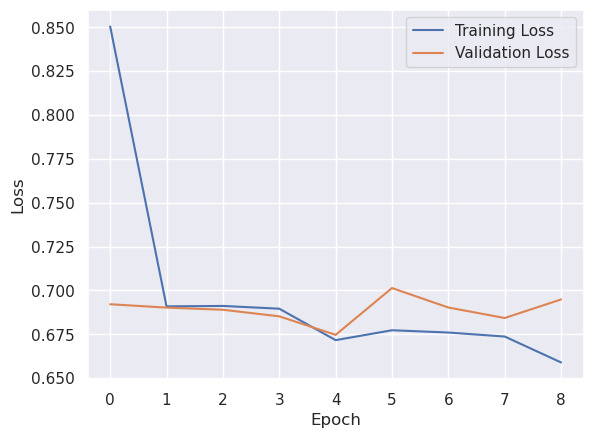

16/16 [==============================] - 1s 64ms/step - loss: 0.6589 - accuracy: 0.5738 - val_loss: 0.6948 - val_accuracy: 0.6042
Epoch 10/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6499 - accuracy: 0.5877

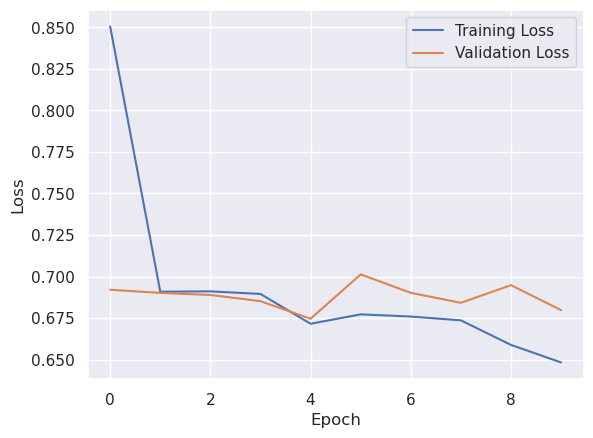

16/16 [==============================] - 1s 65ms/step - loss: 0.6483 - accuracy: 0.5779 - val_loss: 0.6798 - val_accuracy: 0.5312
Epoch 11/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.6053

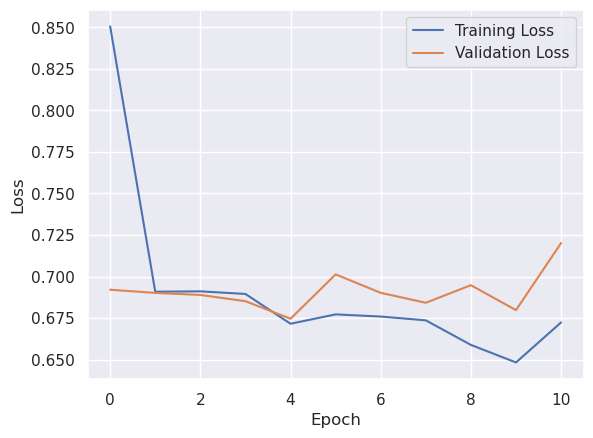

16/16 [==============================] - 1s 64ms/step - loss: 0.6724 - accuracy: 0.5943 - val_loss: 0.7202 - val_accuracy: 0.5625
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.5861

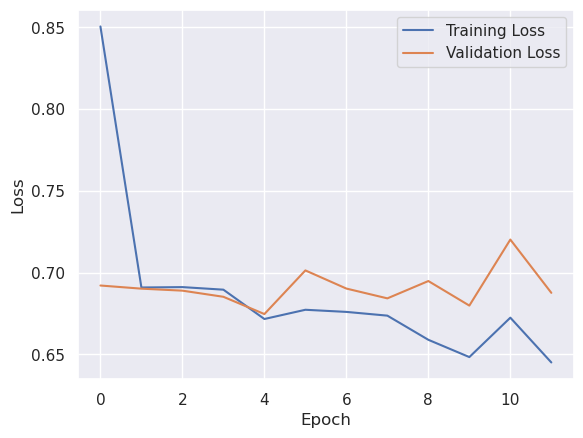

16/16 [==============================] - 1s 64ms/step - loss: 0.6451 - accuracy: 0.5861 - val_loss: 0.6876 - val_accuracy: 0.5625
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6107

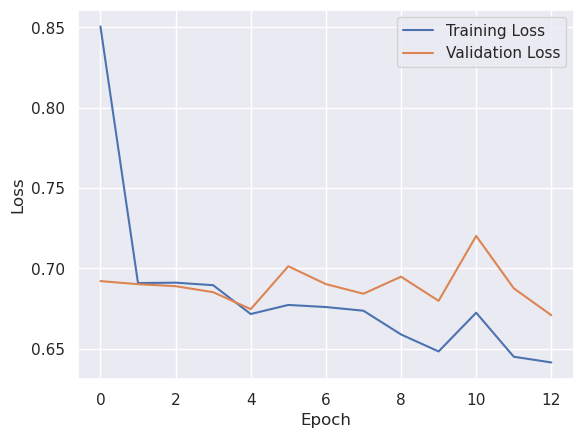

16/16 [==============================] - 1s 63ms/step - loss: 0.6415 - accuracy: 0.6107 - val_loss: 0.6709 - val_accuracy: 0.5625
Epoch 14/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6228 - accuracy: 0.6140

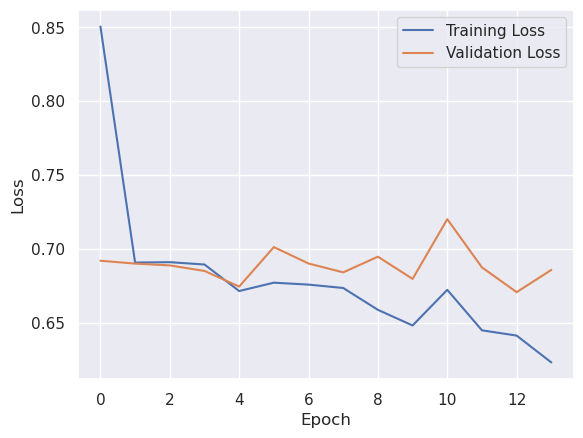

16/16 [==============================] - 1s 62ms/step - loss: 0.6233 - accuracy: 0.6230 - val_loss: 0.6859 - val_accuracy: 0.6458
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.6557

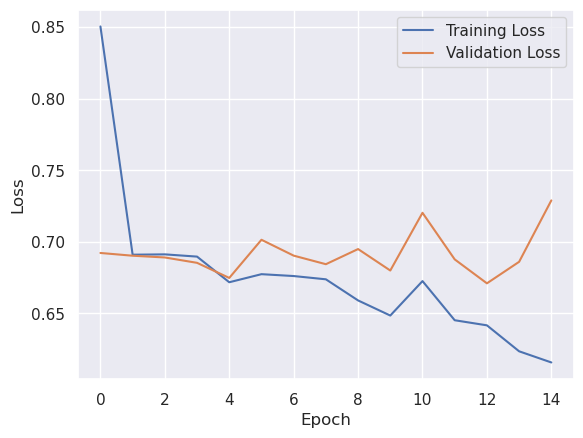

16/16 [==============================] - 1s 65ms/step - loss: 0.6155 - accuracy: 0.6557 - val_loss: 0.7288 - val_accuracy: 0.5938
Epoch 16/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6298 - accuracy: 0.6583

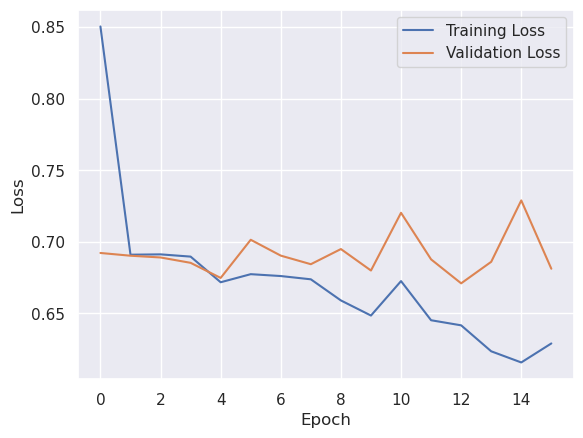

16/16 [==============================] - 1s 66ms/step - loss: 0.6288 - accuracy: 0.6680 - val_loss: 0.6811 - val_accuracy: 0.5521
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.6598

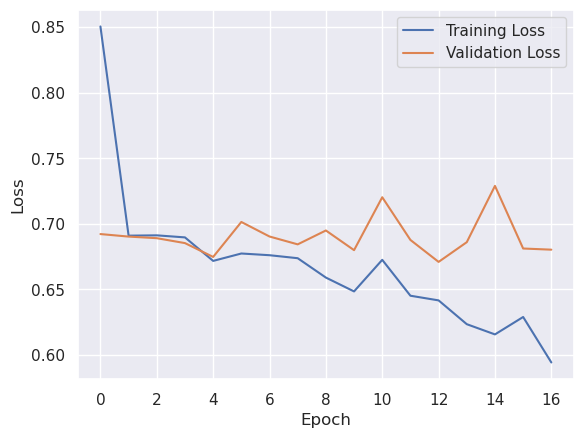

16/16 [==============================] - 1s 64ms/step - loss: 0.5941 - accuracy: 0.6598 - val_loss: 0.6802 - val_accuracy: 0.6875
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.6721

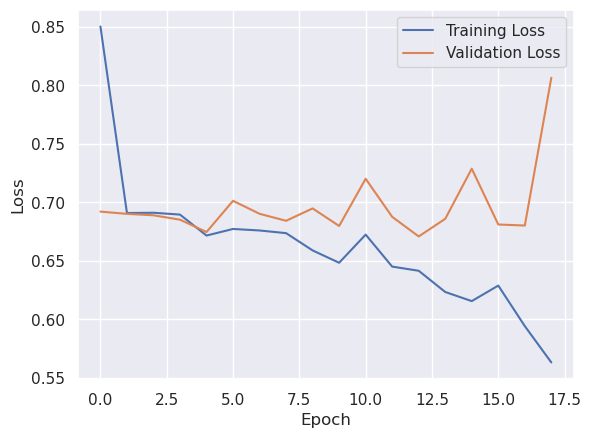

16/16 [==============================] - 1s 65ms/step - loss: 0.5631 - accuracy: 0.6721 - val_loss: 0.8066 - val_accuracy: 0.6146
Epoch 19/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6483 - accuracy: 0.6360

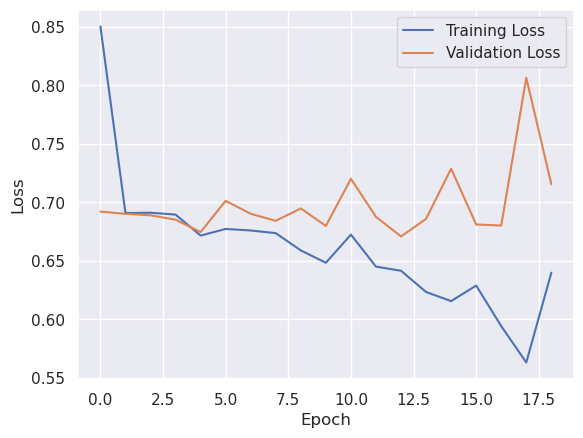

16/16 [==============================] - 1s 65ms/step - loss: 0.6398 - accuracy: 0.6311 - val_loss: 0.7156 - val_accuracy: 0.5312
Epoch 20/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5506 - accuracy: 0.6917

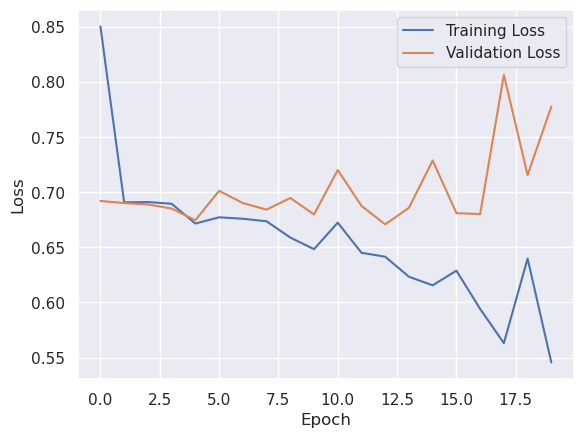

16/16 [==============================] - 1s 66ms/step - loss: 0.5455 - accuracy: 0.6953 - val_loss: 0.7777 - val_accuracy: 0.4688
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6270

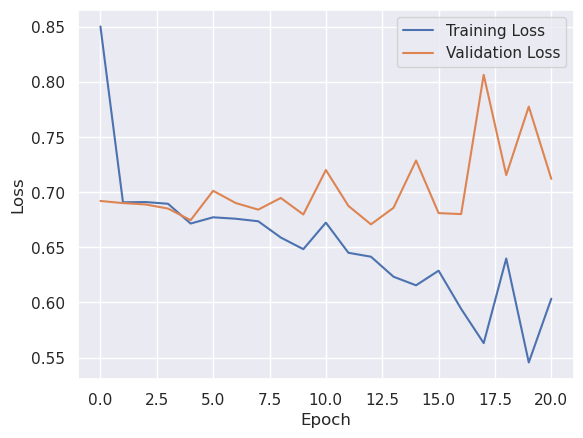

16/16 [==============================] - 1s 65ms/step - loss: 0.6034 - accuracy: 0.6270 - val_loss: 0.7122 - val_accuracy: 0.6562
Epoch 22/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5870 - accuracy: 0.6798

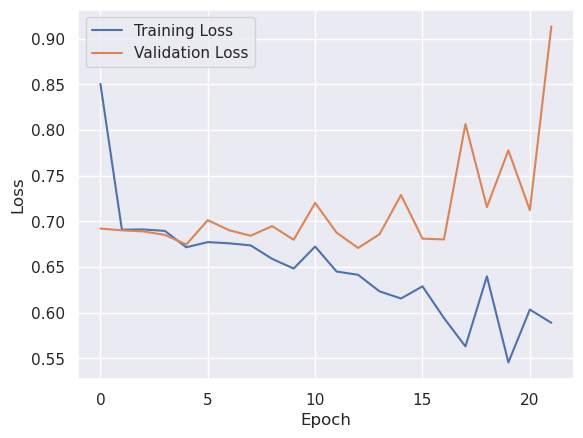

16/16 [==============================] - 1s 65ms/step - loss: 0.5889 - accuracy: 0.6762 - val_loss: 0.9134 - val_accuracy: 0.5833
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.6270

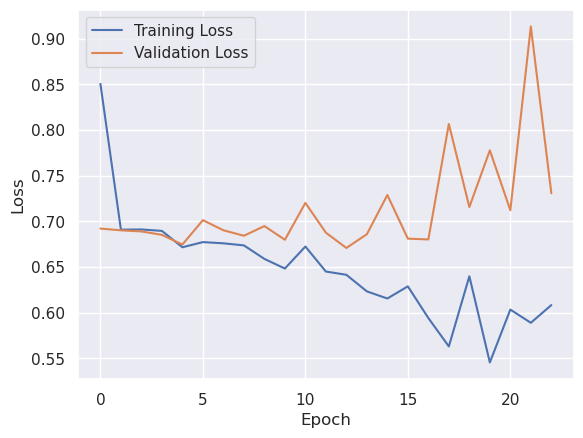

16/16 [==============================] - 1s 63ms/step - loss: 0.6083 - accuracy: 0.6270 - val_loss: 0.7308 - val_accuracy: 0.5208
Epoch 24/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5756 - accuracy: 0.6184

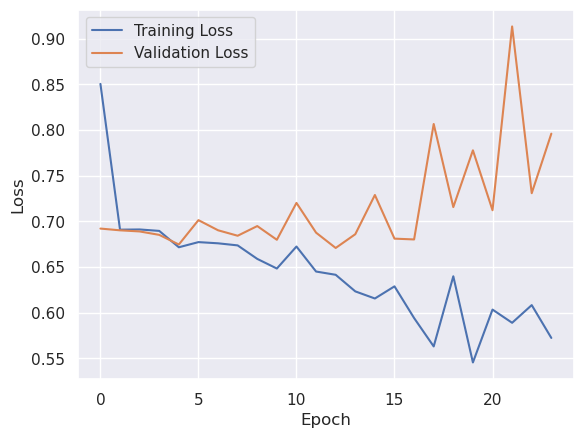

16/16 [==============================] - 1s 63ms/step - loss: 0.5724 - accuracy: 0.6148 - val_loss: 0.7960 - val_accuracy: 0.5833
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7090

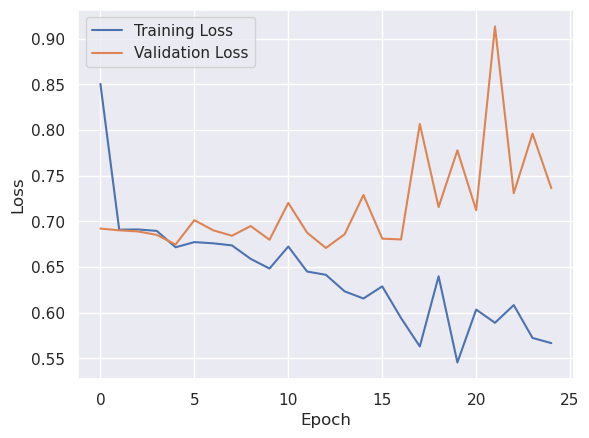

16/16 [==============================] - 1s 64ms/step - loss: 0.5667 - accuracy: 0.7090 - val_loss: 0.7363 - val_accuracy: 0.5417
Epoch 26/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5193 - accuracy: 0.7105

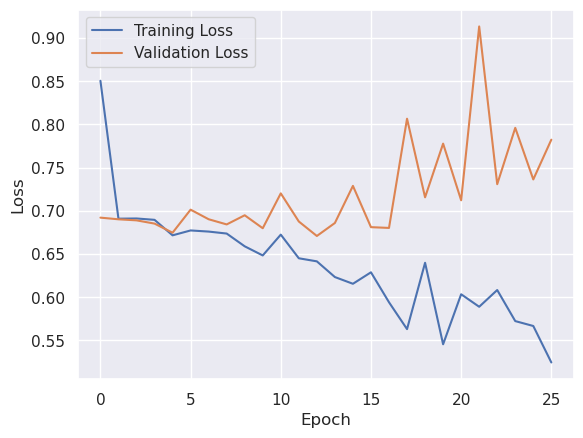

16/16 [==============================] - 1s 64ms/step - loss: 0.5245 - accuracy: 0.7008 - val_loss: 0.7823 - val_accuracy: 0.5208
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7377

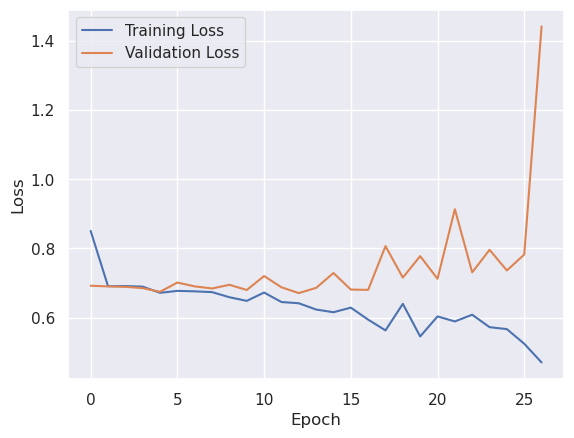

16/16 [==============================] - 1s 63ms/step - loss: 0.4704 - accuracy: 0.7377 - val_loss: 1.4415 - val_accuracy: 0.5104
Epoch 28/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6447 - accuracy: 0.7208

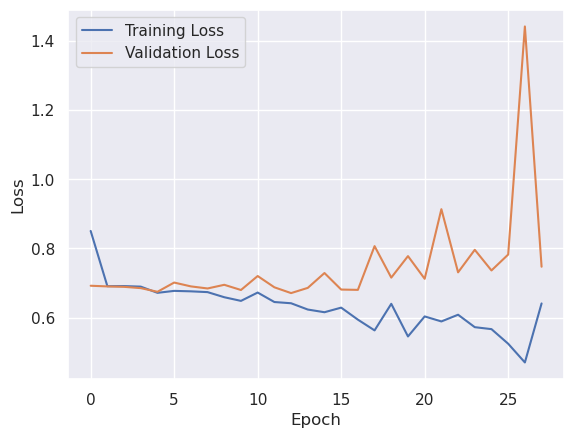

16/16 [==============================] - 1s 62ms/step - loss: 0.6409 - accuracy: 0.7213 - val_loss: 0.7471 - val_accuracy: 0.5625
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7295

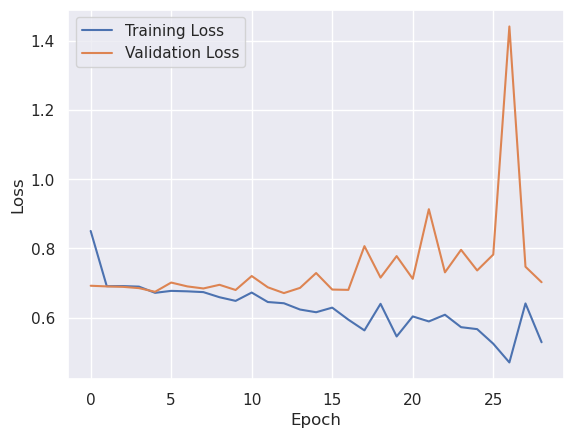

16/16 [==============================] - 1s 63ms/step - loss: 0.5288 - accuracy: 0.7295 - val_loss: 0.7023 - val_accuracy: 0.5312
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.7090

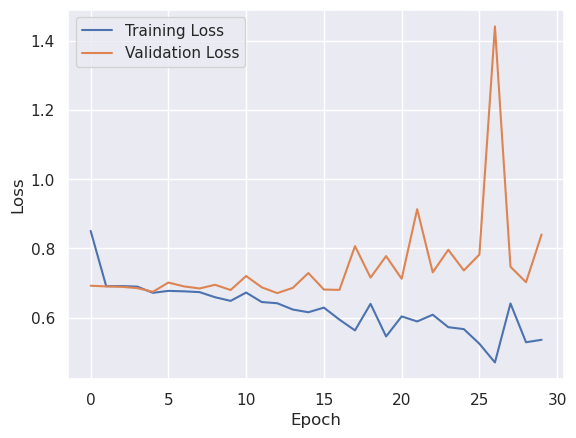

16/16 [==============================] - 1s 63ms/step - loss: 0.5359 - accuracy: 0.7090 - val_loss: 0.8402 - val_accuracy: 0.5417
Epoch 31/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5430 - accuracy: 0.6886

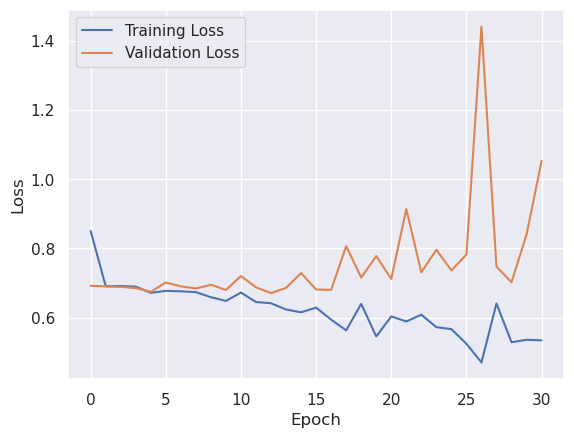

16/16 [==============================] - 1s 65ms/step - loss: 0.5342 - accuracy: 0.7008 - val_loss: 1.0526 - val_accuracy: 0.6146
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7295

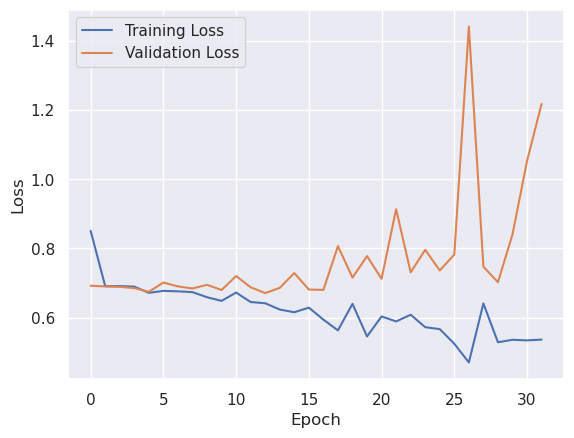

16/16 [==============================] - 1s 63ms/step - loss: 0.5364 - accuracy: 0.7295 - val_loss: 1.2176 - val_accuracy: 0.5833
Epoch 33/100
15/16 [===========================>..] - ETA: 0s - loss: 0.5988 - accuracy: 0.6974

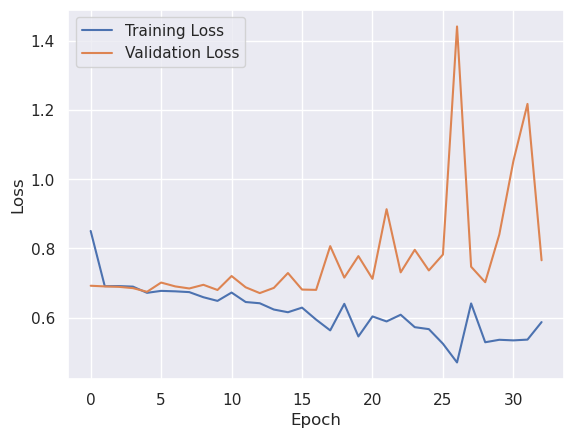

16/16 [==============================] - 1s 63ms/step - loss: 0.5870 - accuracy: 0.7090 - val_loss: 0.7657 - val_accuracy: 0.5625
Epoch 34/100
16/16 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.7623

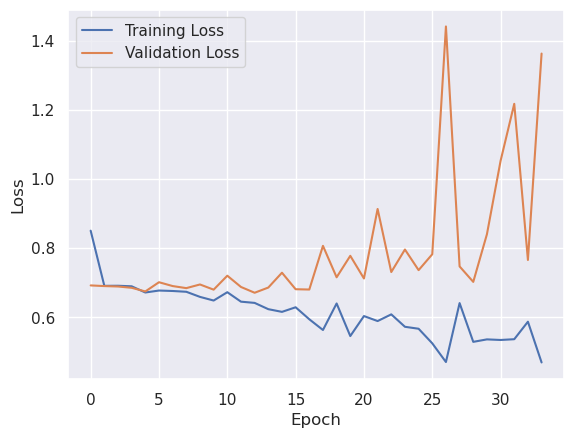

16/16 [==============================] - 1s 64ms/step - loss: 0.4692 - accuracy: 0.7623 - val_loss: 1.3631 - val_accuracy: 0.4896
Epoch 35/100
15/16 [===========================>..] - ETA: 0s - loss: 0.4624 - accuracy: 0.7851

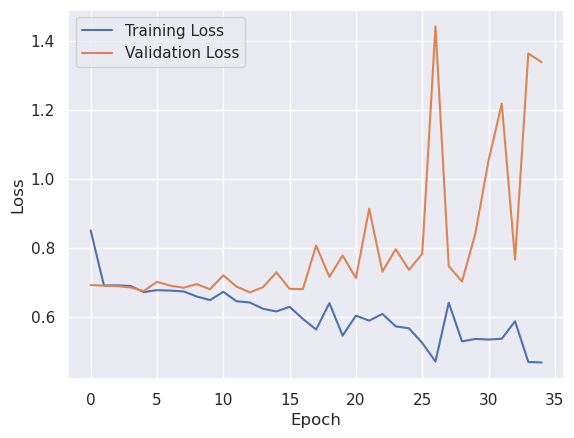

16/16 [==============================] - 1s 67ms/step - loss: 0.4677 - accuracy: 0.7787 - val_loss: 1.3381 - val_accuracy: 0.4583
Epoch 36/100
16/16 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.7377

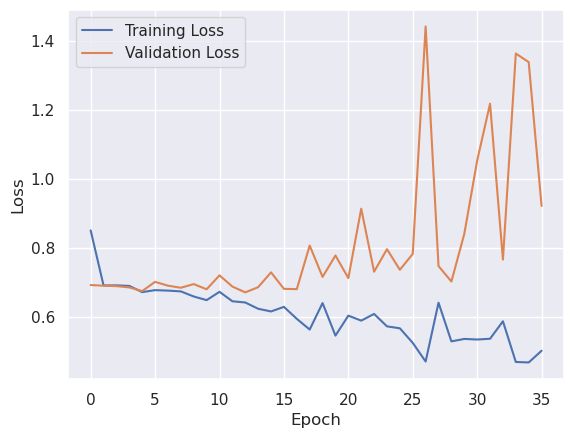

16/16 [==============================] - 1s 64ms/step - loss: 0.5016 - accuracy: 0.7377 - val_loss: 0.9213 - val_accuracy: 0.7083
Epoch 37/100
16/16 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7746

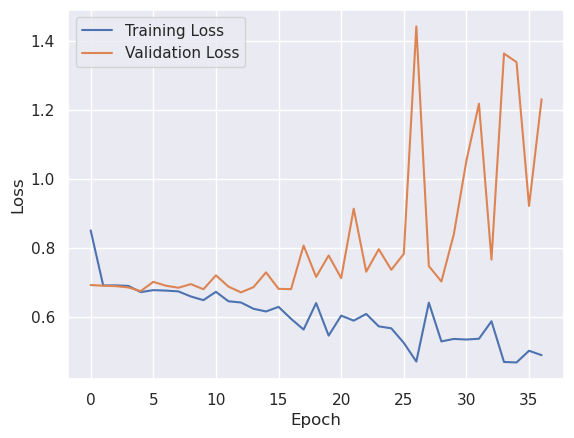

16/16 [==============================] - 1s 65ms/step - loss: 0.4889 - accuracy: 0.7746 - val_loss: 1.2305 - val_accuracy: 0.6146
Epoch 38/100
16/16 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.7787

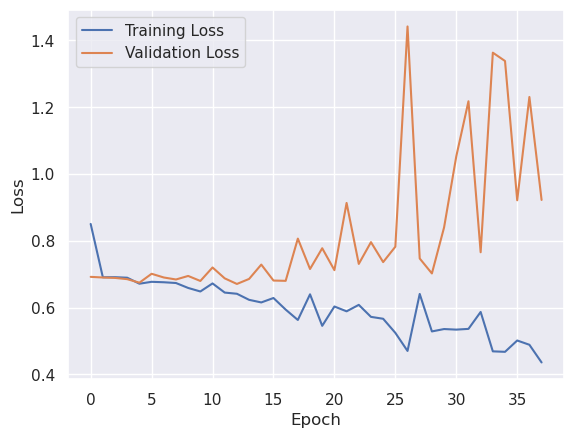

16/16 [==============================] - 1s 63ms/step - loss: 0.4359 - accuracy: 0.7787 - val_loss: 0.9223 - val_accuracy: 0.6562
Epoch 39/100
16/16 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.7992

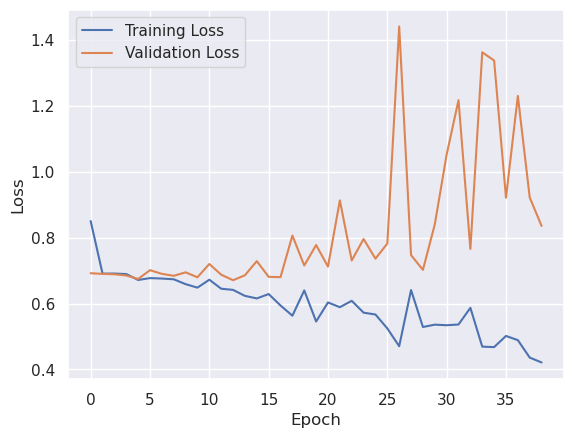

16/16 [==============================] - 1s 65ms/step - loss: 0.4211 - accuracy: 0.7992 - val_loss: 0.8357 - val_accuracy: 0.6771
Epoch 40/100
16/16 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8238

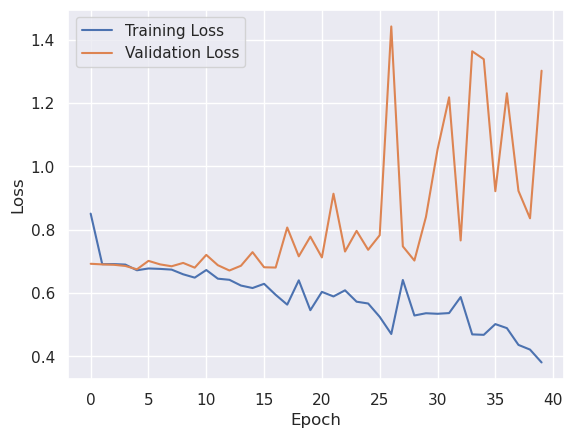

16/16 [==============================] - 1s 63ms/step - loss: 0.3805 - accuracy: 0.8238 - val_loss: 1.3017 - val_accuracy: 0.6042
Epoch 41/100
16/16 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8361

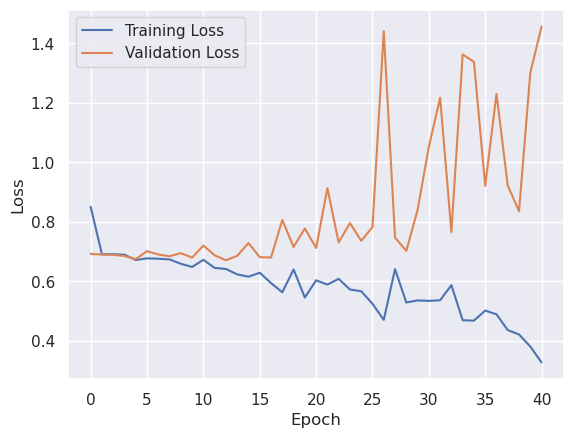

16/16 [==============================] - 1s 64ms/step - loss: 0.3271 - accuracy: 0.8361 - val_loss: 1.4573 - val_accuracy: 0.6250
Epoch 42/100
16/16 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8115

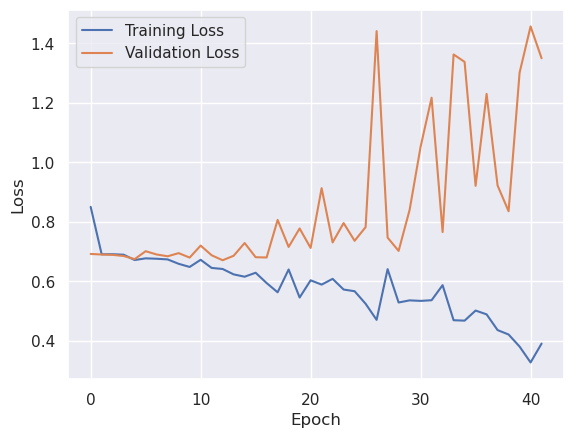

16/16 [==============================] - 1s 62ms/step - loss: 0.3906 - accuracy: 0.8115 - val_loss: 1.3503 - val_accuracy: 0.6771
Epoch 43/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3853 - accuracy: 0.8375

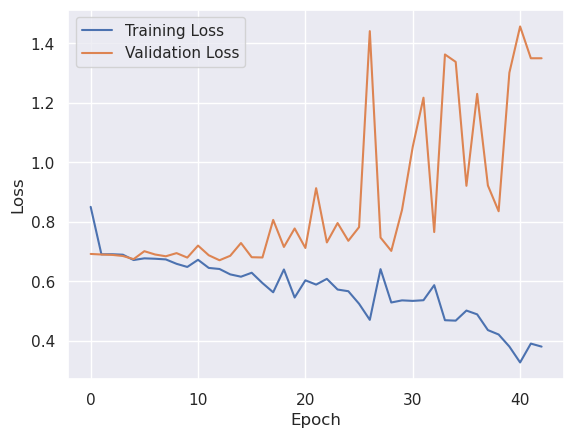

16/16 [==============================] - 1s 63ms/step - loss: 0.3804 - accuracy: 0.8402 - val_loss: 1.3503 - val_accuracy: 0.5833
Epoch 44/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3951 - accuracy: 0.8246

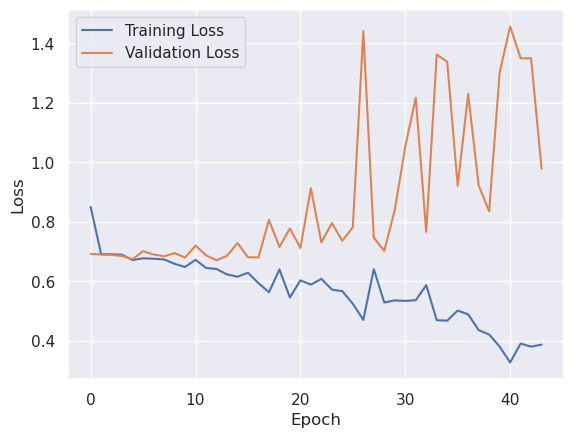

16/16 [==============================] - 1s 65ms/step - loss: 0.3870 - accuracy: 0.8320 - val_loss: 0.9788 - val_accuracy: 0.6771
Epoch 45/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3695 - accuracy: 0.8458

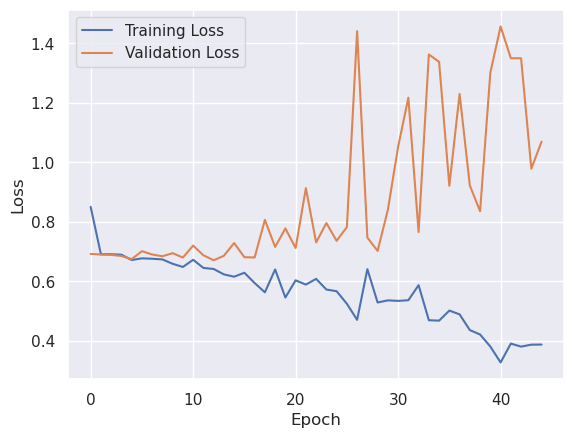

16/16 [==============================] - 1s 66ms/step - loss: 0.3873 - accuracy: 0.8398 - val_loss: 1.0697 - val_accuracy: 0.5729
Epoch 46/100
16/16 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8033

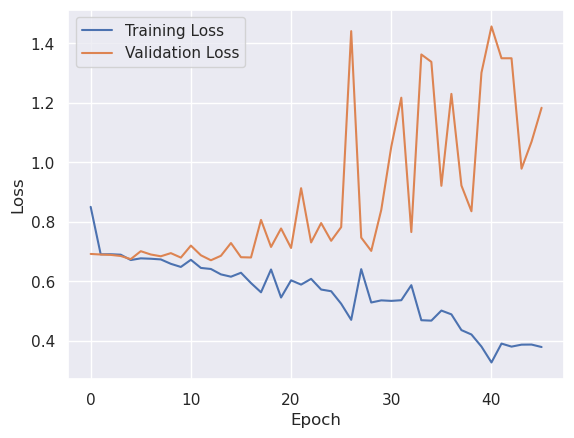

16/16 [==============================] - 1s 63ms/step - loss: 0.3790 - accuracy: 0.8033 - val_loss: 1.1837 - val_accuracy: 0.6146
Epoch 47/100
16/16 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.9016

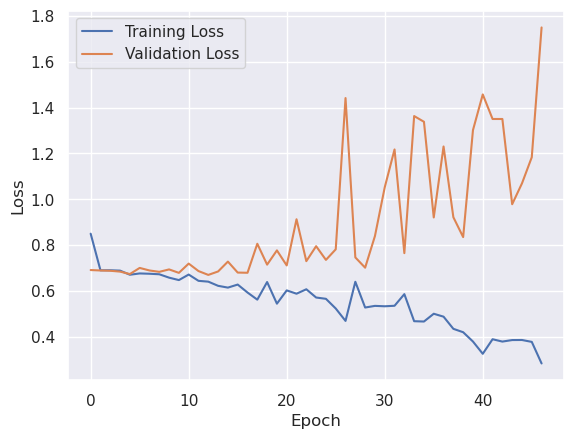

16/16 [==============================] - 1s 64ms/step - loss: 0.2851 - accuracy: 0.9016 - val_loss: 1.7492 - val_accuracy: 0.6250
Epoch 48/100
16/16 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9180

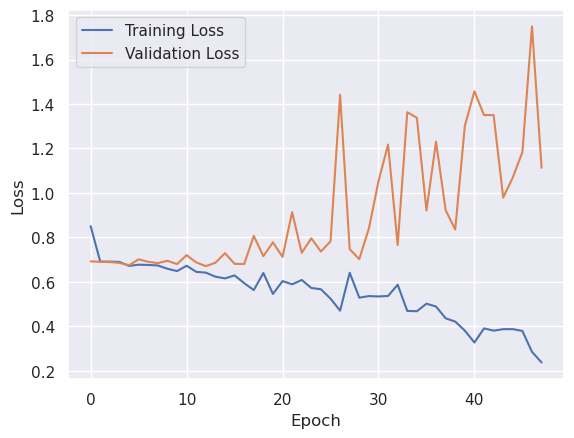

16/16 [==============================] - 1s 63ms/step - loss: 0.2373 - accuracy: 0.9180 - val_loss: 1.1132 - val_accuracy: 0.7396
Epoch 49/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2436 - accuracy: 0.9125

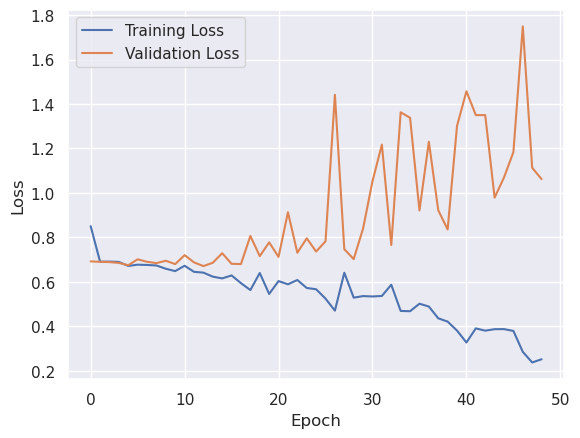

16/16 [==============================] - 1s 64ms/step - loss: 0.2516 - accuracy: 0.9102 - val_loss: 1.0623 - val_accuracy: 0.7500
Epoch 50/100
16/16 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9303

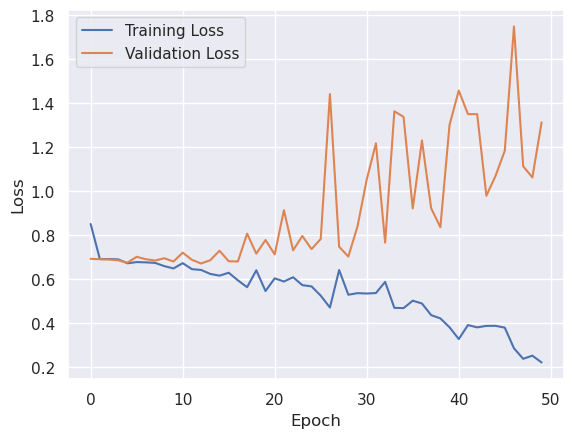

16/16 [==============================] - 1s 63ms/step - loss: 0.2207 - accuracy: 0.9303 - val_loss: 1.3129 - val_accuracy: 0.6875
Epoch 51/100
16/16 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8566

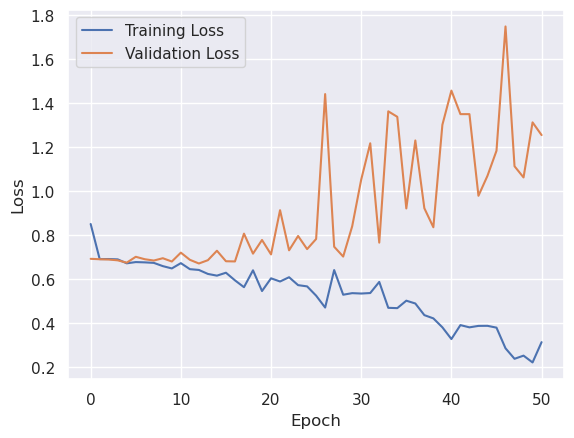

16/16 [==============================] - 1s 64ms/step - loss: 0.3130 - accuracy: 0.8566 - val_loss: 1.2550 - val_accuracy: 0.5625
Epoch 52/100
16/16 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9139

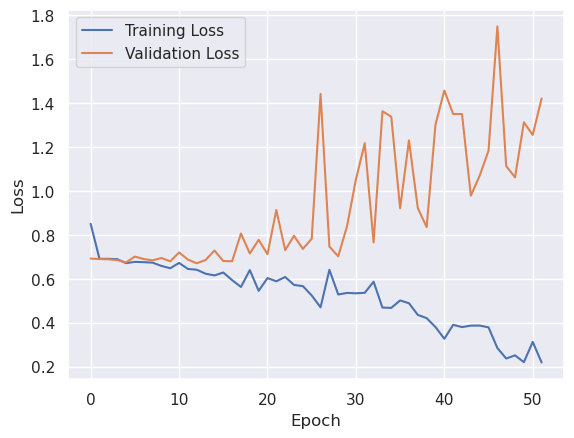

16/16 [==============================] - 1s 64ms/step - loss: 0.2193 - accuracy: 0.9139 - val_loss: 1.4208 - val_accuracy: 0.7292
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.8770

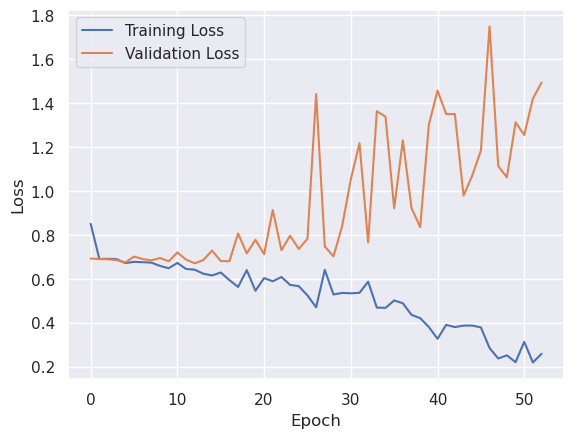

16/16 [==============================] - 1s 66ms/step - loss: 0.2587 - accuracy: 0.8770 - val_loss: 1.4939 - val_accuracy: 0.6875
Epoch 54/100
15/16 [===========================>..] - ETA: 0s - loss: 0.2053 - accuracy: 0.9298

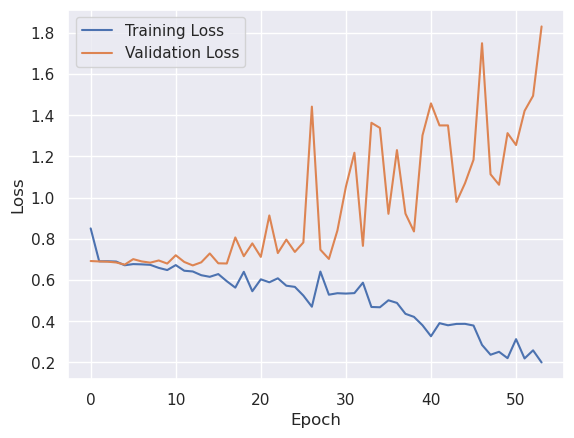

16/16 [==============================] - 1s 64ms/step - loss: 0.1999 - accuracy: 0.9303 - val_loss: 1.8306 - val_accuracy: 0.5833
Epoch 55/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1847 - accuracy: 0.9386

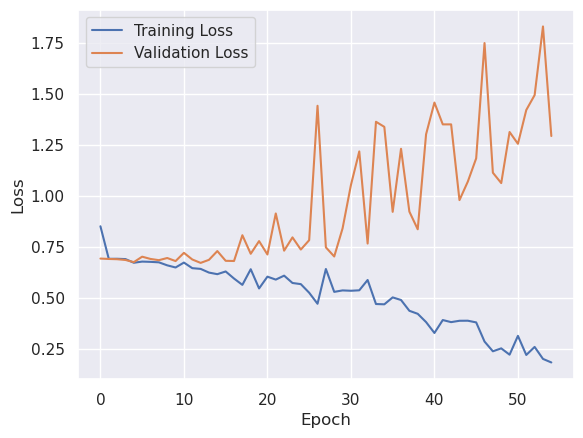

16/16 [==============================] - 1s 66ms/step - loss: 0.1826 - accuracy: 0.9385 - val_loss: 1.2932 - val_accuracy: 0.6667
Epoch 56/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1374 - accuracy: 0.9333

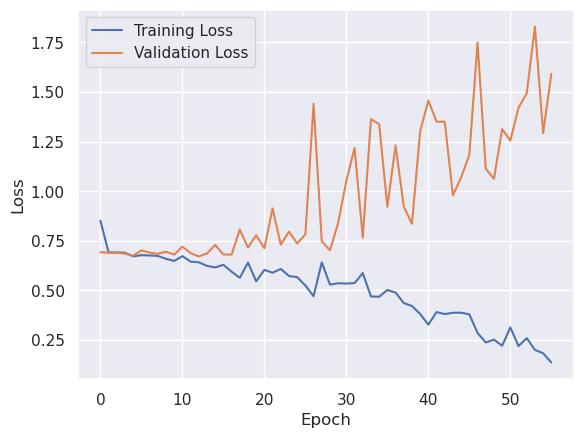

16/16 [==============================] - 1s 62ms/step - loss: 0.1364 - accuracy: 0.9344 - val_loss: 1.5916 - val_accuracy: 0.7083
Epoch 57/100
16/16 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8852

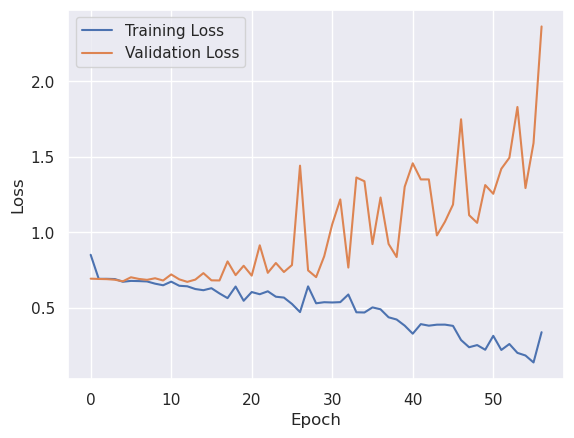

16/16 [==============================] - 1s 63ms/step - loss: 0.3370 - accuracy: 0.8852 - val_loss: 2.3648 - val_accuracy: 0.5521
Epoch 58/100
16/16 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9180

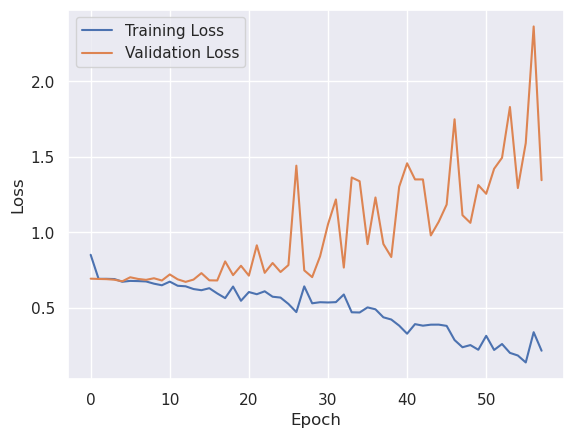

16/16 [==============================] - 1s 64ms/step - loss: 0.2143 - accuracy: 0.9180 - val_loss: 1.3453 - val_accuracy: 0.6354
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9385

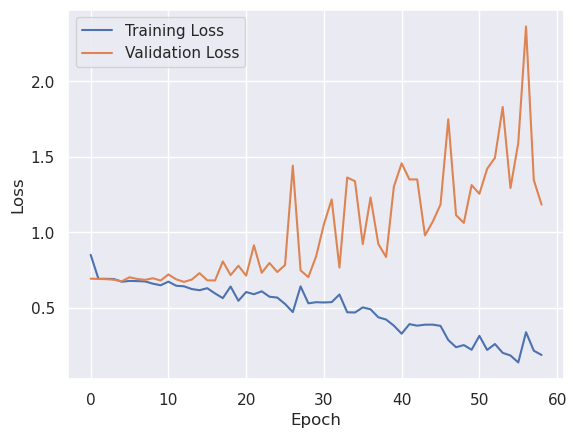

16/16 [==============================] - 1s 64ms/step - loss: 0.1860 - accuracy: 0.9385 - val_loss: 1.1835 - val_accuracy: 0.7396
Epoch 60/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9375

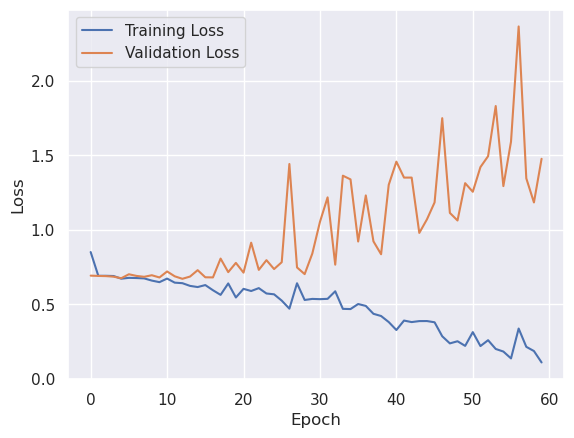

16/16 [==============================] - 1s 75ms/step - loss: 0.1094 - accuracy: 0.9414 - val_loss: 1.4764 - val_accuracy: 0.7396
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9590

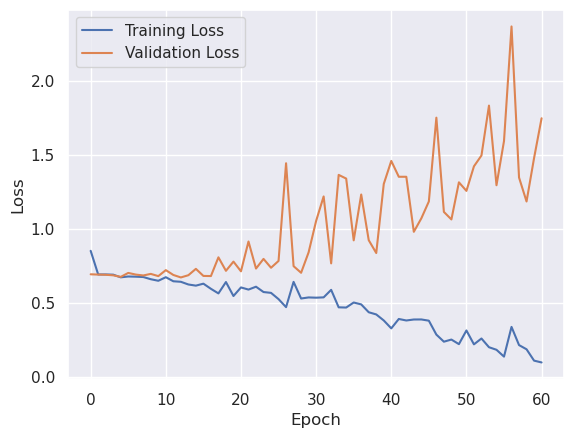

16/16 [==============================] - 1s 64ms/step - loss: 0.0971 - accuracy: 0.9590 - val_loss: 1.7452 - val_accuracy: 0.6979
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9508

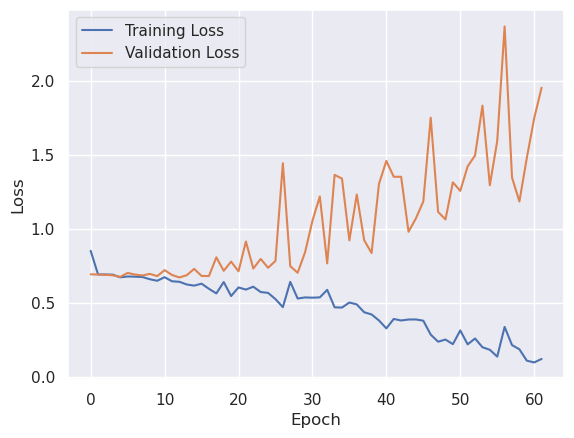

16/16 [==============================] - 1s 63ms/step - loss: 0.1208 - accuracy: 0.9508 - val_loss: 1.9512 - val_accuracy: 0.6979
Epoch 63/100
16/16 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9713

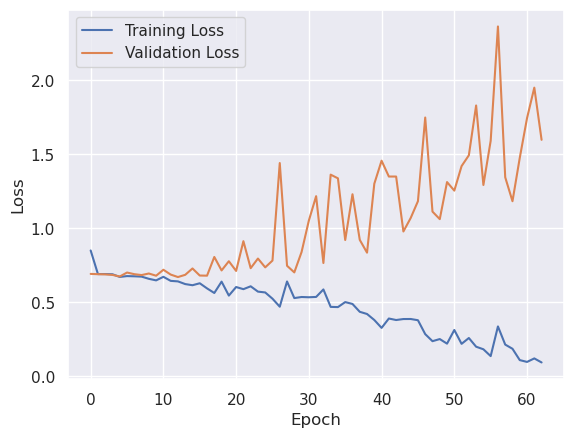

16/16 [==============================] - 1s 64ms/step - loss: 0.0936 - accuracy: 0.9713 - val_loss: 1.5985 - val_accuracy: 0.7292
Epoch 64/100
16/16 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9631

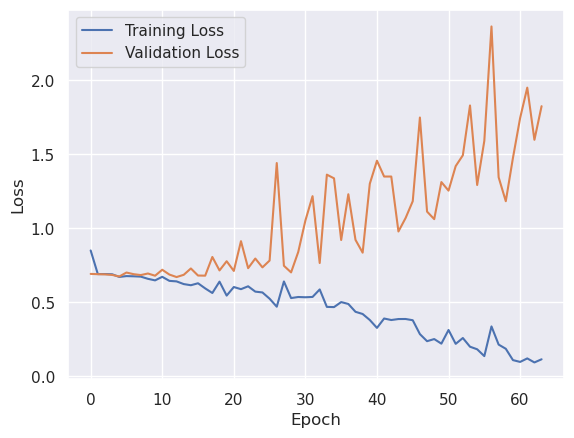

16/16 [==============================] - 1s 64ms/step - loss: 0.1150 - accuracy: 0.9631 - val_loss: 1.8258 - val_accuracy: 0.7396
Epoch 65/100
16/16 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9467

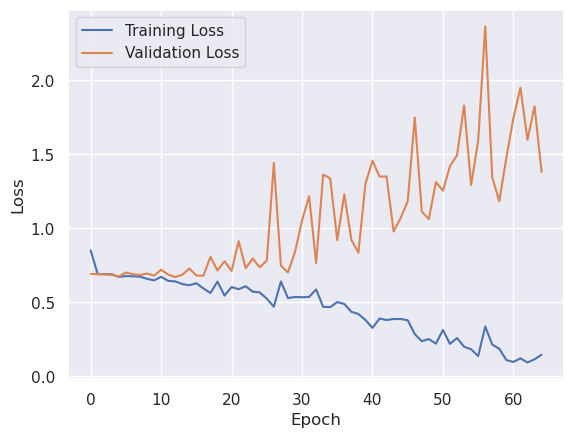

16/16 [==============================] - 1s 65ms/step - loss: 0.1455 - accuracy: 0.9467 - val_loss: 1.3815 - val_accuracy: 0.7396
Epoch 66/100
16/16 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9262

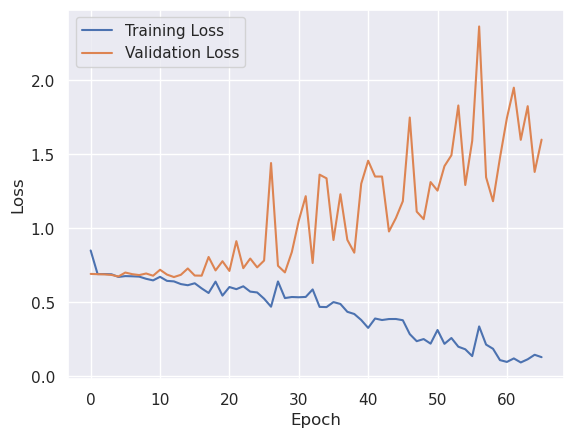

16/16 [==============================] - 1s 64ms/step - loss: 0.1293 - accuracy: 0.9262 - val_loss: 1.5996 - val_accuracy: 0.6979
Epoch 67/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0710 - accuracy: 0.9750

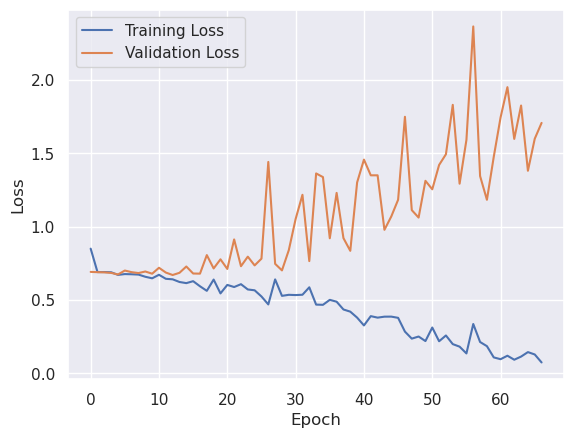

16/16 [==============================] - 1s 63ms/step - loss: 0.0750 - accuracy: 0.9713 - val_loss: 1.7074 - val_accuracy: 0.7188
Epoch 68/100
16/16 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9057

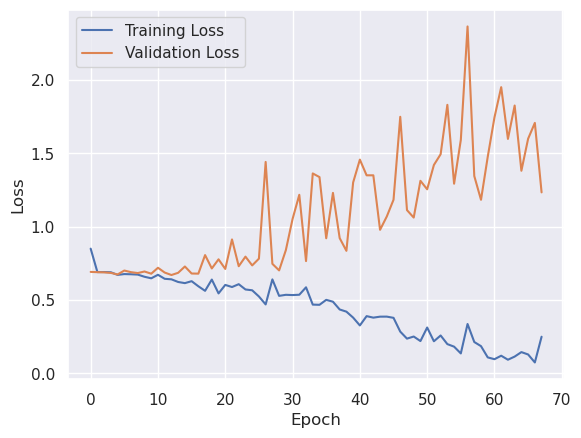

16/16 [==============================] - 1s 64ms/step - loss: 0.2502 - accuracy: 0.9057 - val_loss: 1.2340 - val_accuracy: 0.7292
Epoch 69/100
16/16 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9549

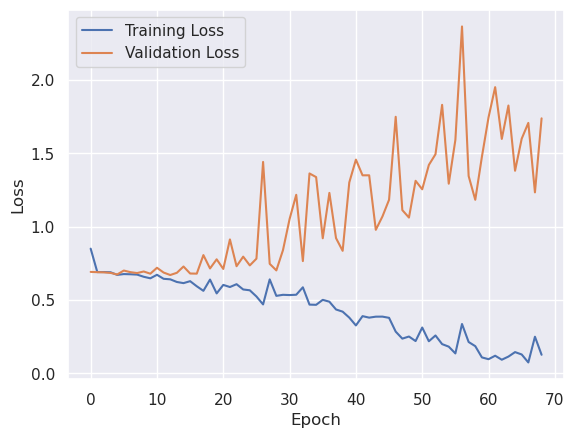

16/16 [==============================] - 1s 66ms/step - loss: 0.1273 - accuracy: 0.9549 - val_loss: 1.7386 - val_accuracy: 0.6562
Epoch 70/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9708

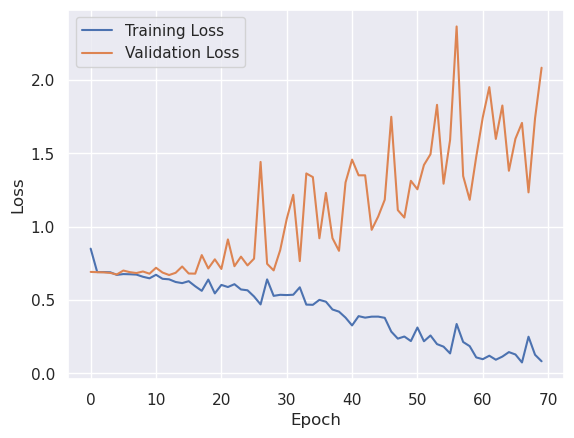

16/16 [==============================] - 1s 65ms/step - loss: 0.0829 - accuracy: 0.9727 - val_loss: 2.0835 - val_accuracy: 0.5729
Epoch 71/100
16/16 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9631

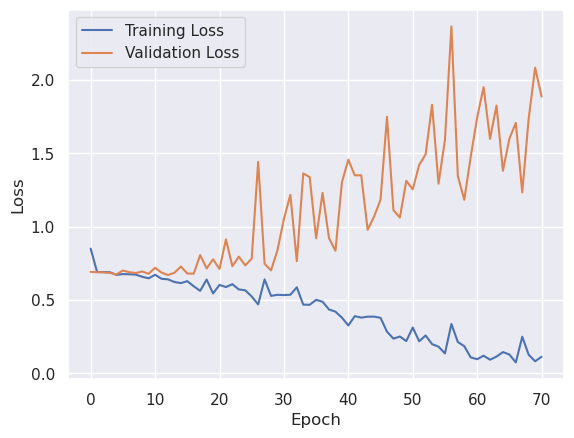

16/16 [==============================] - 1s 63ms/step - loss: 0.1135 - accuracy: 0.9631 - val_loss: 1.8865 - val_accuracy: 0.6458
Epoch 72/100
16/16 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9262

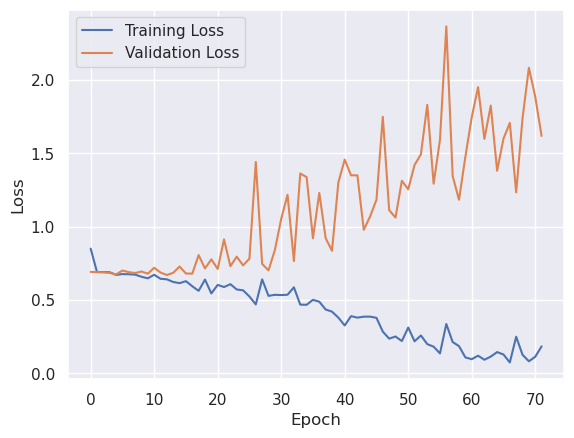

16/16 [==============================] - 1s 64ms/step - loss: 0.1846 - accuracy: 0.9262 - val_loss: 1.6185 - val_accuracy: 0.6979
Epoch 73/100
16/16 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9549

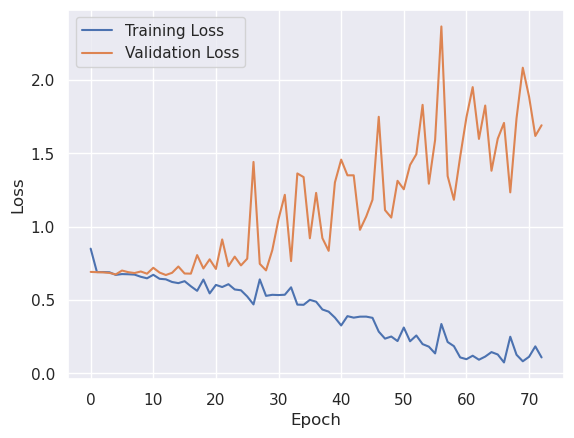

16/16 [==============================] - 1s 64ms/step - loss: 0.1092 - accuracy: 0.9549 - val_loss: 1.6914 - val_accuracy: 0.6875
Epoch 74/100
16/16 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9754

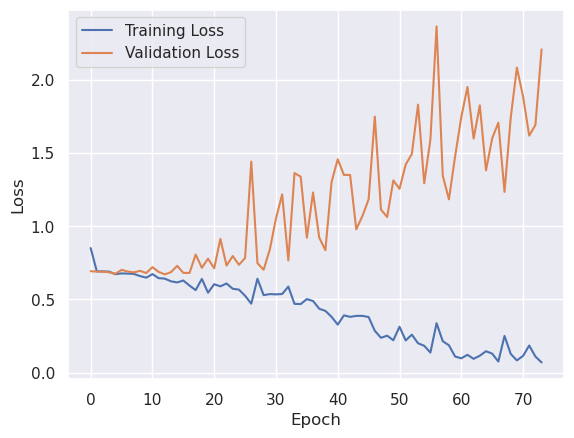

16/16 [==============================] - 1s 63ms/step - loss: 0.0688 - accuracy: 0.9754 - val_loss: 2.2080 - val_accuracy: 0.6354
Epoch 75/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0668 - accuracy: 0.9605

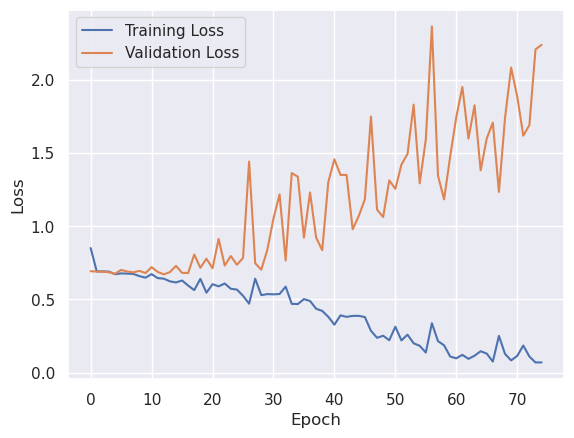

16/16 [==============================] - 1s 64ms/step - loss: 0.0692 - accuracy: 0.9590 - val_loss: 2.2392 - val_accuracy: 0.6979
Epoch 76/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0864 - accuracy: 0.9667

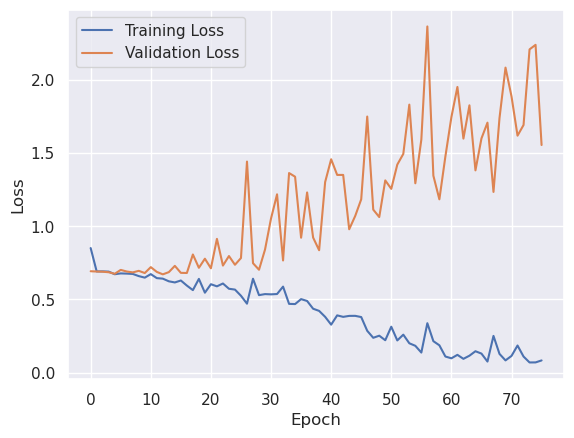

16/16 [==============================] - 1s 67ms/step - loss: 0.0827 - accuracy: 0.9688 - val_loss: 1.5546 - val_accuracy: 0.7500
Epoch 77/100
16/16 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9713

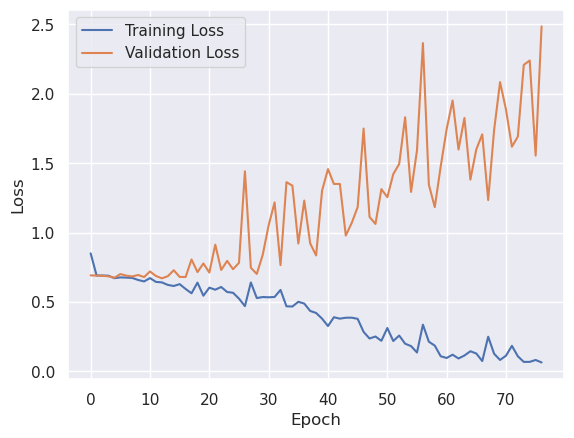

16/16 [==============================] - 1s 64ms/step - loss: 0.0649 - accuracy: 0.9713 - val_loss: 2.4846 - val_accuracy: 0.6562
Epoch 78/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9417

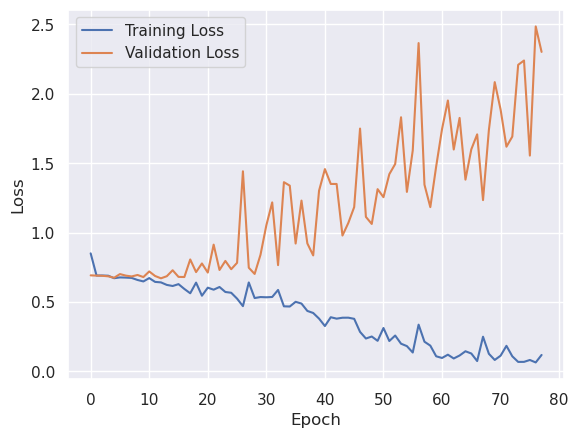

16/16 [==============================] - 1s 65ms/step - loss: 0.1188 - accuracy: 0.9414 - val_loss: 2.3013 - val_accuracy: 0.6354
Epoch 79/100
16/16 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9795

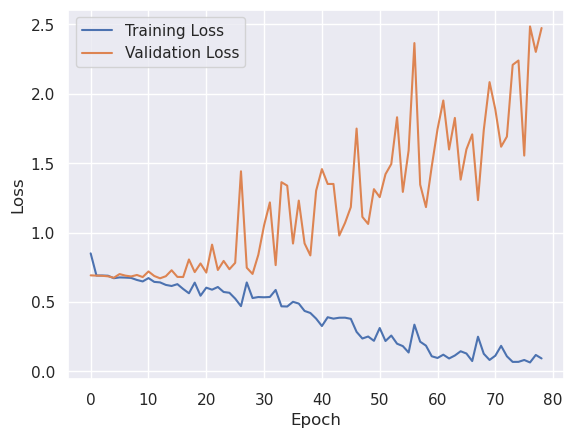

16/16 [==============================] - 1s 66ms/step - loss: 0.0937 - accuracy: 0.9795 - val_loss: 2.4733 - val_accuracy: 0.6771
Epoch 80/100
16/16 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9713

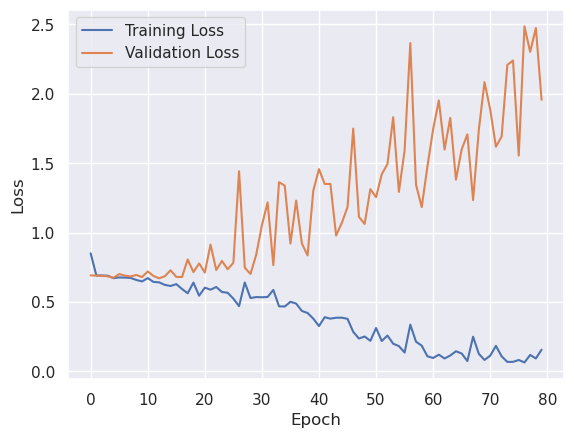

16/16 [==============================] - 1s 64ms/step - loss: 0.1569 - accuracy: 0.9713 - val_loss: 1.9563 - val_accuracy: 0.6667
Epoch 81/100
16/16 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9344

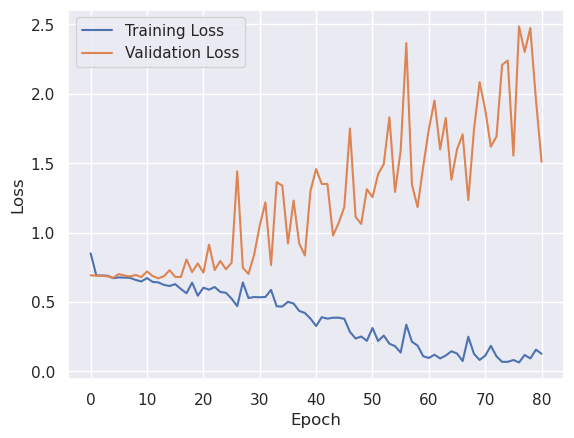

16/16 [==============================] - 1s 64ms/step - loss: 0.1270 - accuracy: 0.9344 - val_loss: 1.5094 - val_accuracy: 0.7083
Epoch 82/100
16/16 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9631

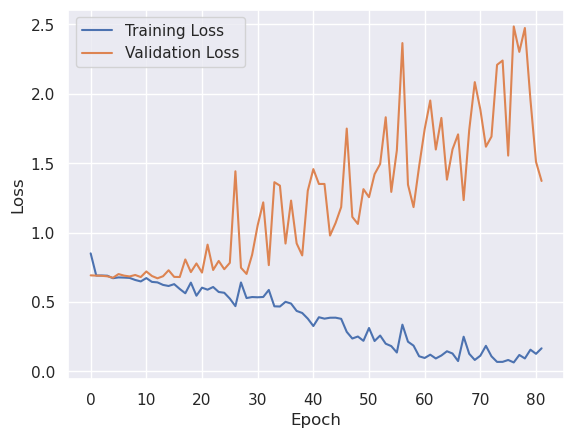

16/16 [==============================] - 1s 64ms/step - loss: 0.1667 - accuracy: 0.9631 - val_loss: 1.3719 - val_accuracy: 0.7396
Epoch 83/100
16/16 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9713

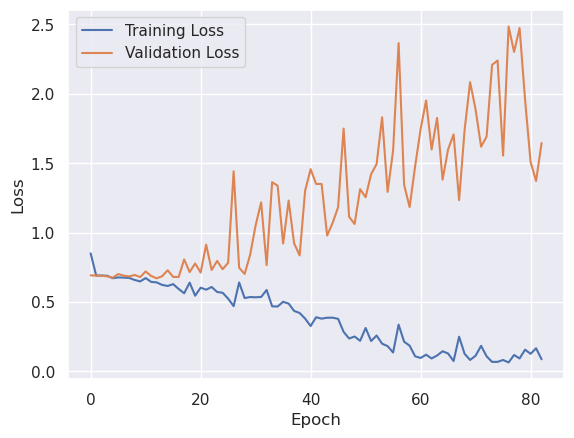

16/16 [==============================] - 1s 63ms/step - loss: 0.0878 - accuracy: 0.9713 - val_loss: 1.6454 - val_accuracy: 0.6562
Epoch 84/100
16/16 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9795

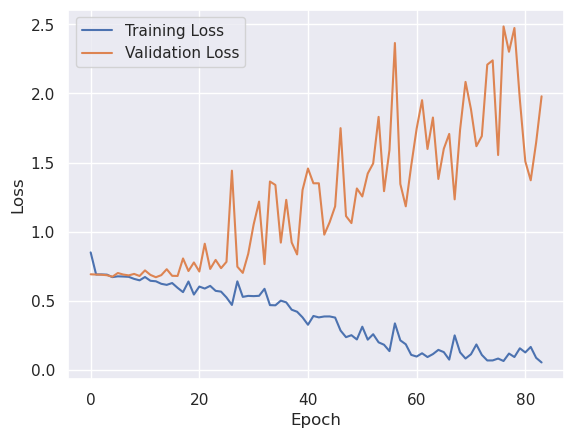

16/16 [==============================] - 1s 66ms/step - loss: 0.0545 - accuracy: 0.9795 - val_loss: 1.9792 - val_accuracy: 0.6875
Epoch 85/100
16/16 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9549

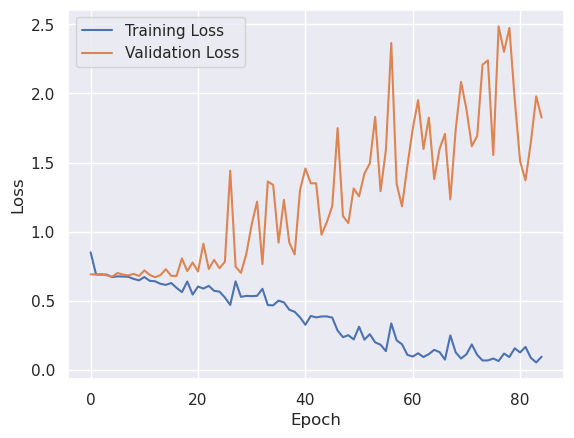

16/16 [==============================] - 1s 63ms/step - loss: 0.0959 - accuracy: 0.9549 - val_loss: 1.8259 - val_accuracy: 0.7396
Epoch 86/100
16/16 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9754

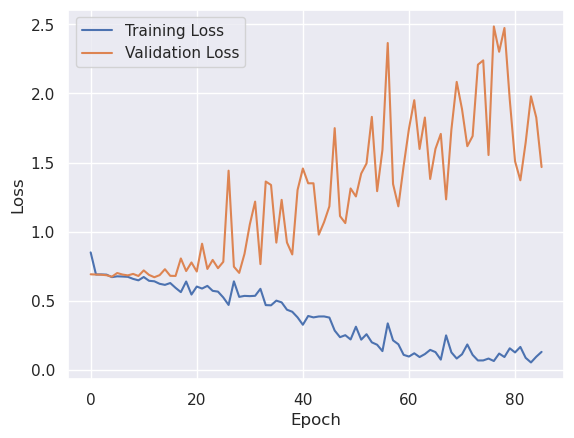

16/16 [==============================] - 1s 64ms/step - loss: 0.1310 - accuracy: 0.9754 - val_loss: 1.4675 - val_accuracy: 0.7083
Epoch 87/100
16/16 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9795

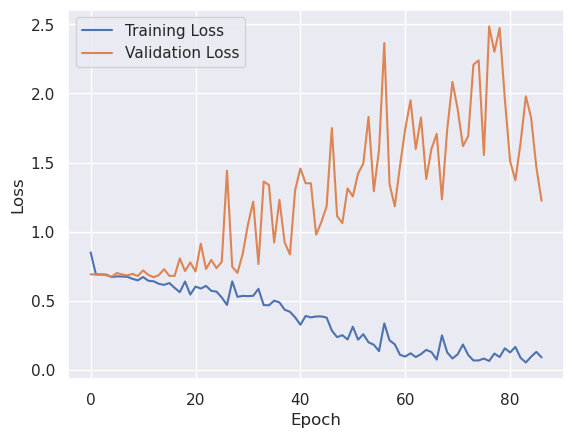

16/16 [==============================] - 1s 66ms/step - loss: 0.0913 - accuracy: 0.9795 - val_loss: 1.2240 - val_accuracy: 0.7188
Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9672

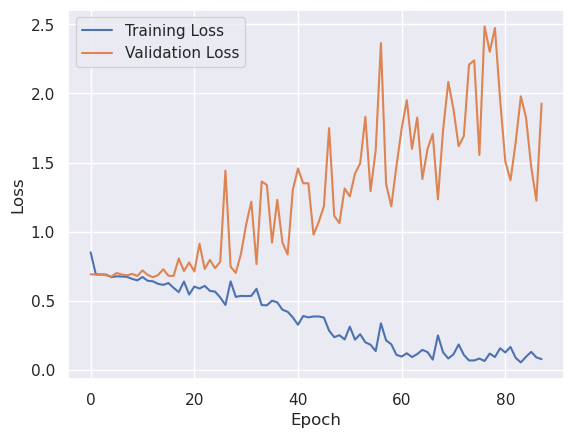

16/16 [==============================] - 1s 63ms/step - loss: 0.0783 - accuracy: 0.9672 - val_loss: 1.9267 - val_accuracy: 0.6771
Epoch 89/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0452 - accuracy: 0.9825

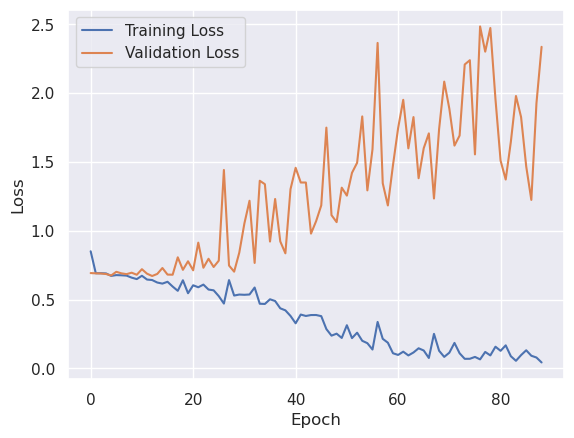

16/16 [==============================] - 1s 64ms/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 2.3365 - val_accuracy: 0.6146
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9836

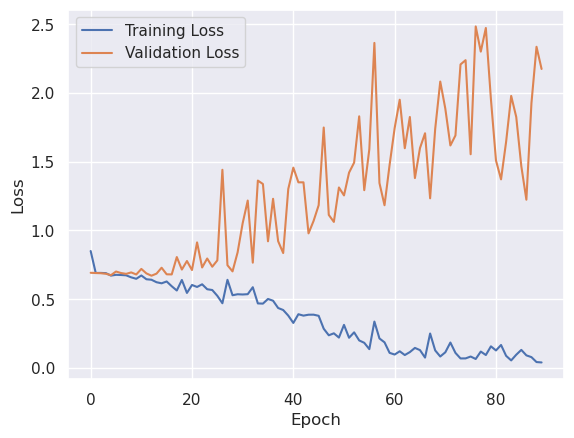

16/16 [==============================] - 1s 63ms/step - loss: 0.0396 - accuracy: 0.9836 - val_loss: 2.1752 - val_accuracy: 0.6875
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9918

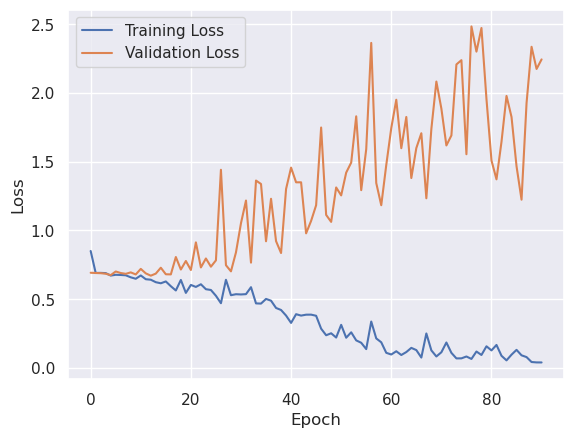

16/16 [==============================] - 1s 63ms/step - loss: 0.0393 - accuracy: 0.9918 - val_loss: 2.2447 - val_accuracy: 0.6562
Epoch 92/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1071 - accuracy: 0.9649

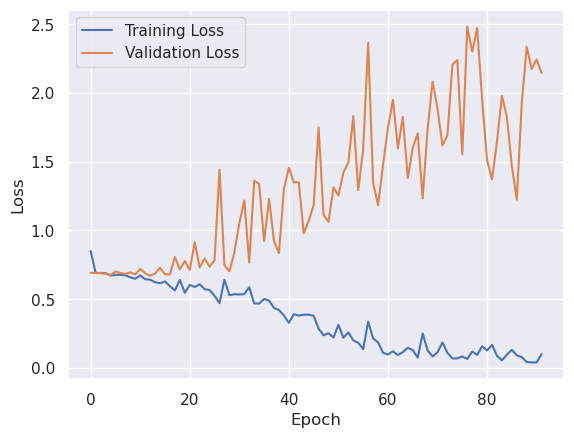

16/16 [==============================] - 1s 66ms/step - loss: 0.1003 - accuracy: 0.9672 - val_loss: 2.1457 - val_accuracy: 0.6458
Epoch 93/100
16/16 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9713

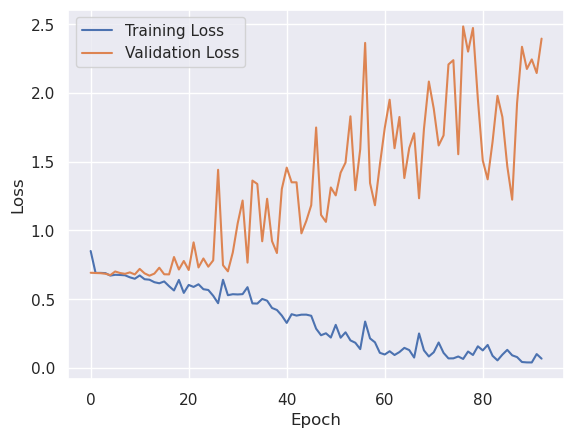

16/16 [==============================] - 1s 64ms/step - loss: 0.0671 - accuracy: 0.9713 - val_loss: 2.3959 - val_accuracy: 0.6250
Epoch 94/100
16/16 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9672

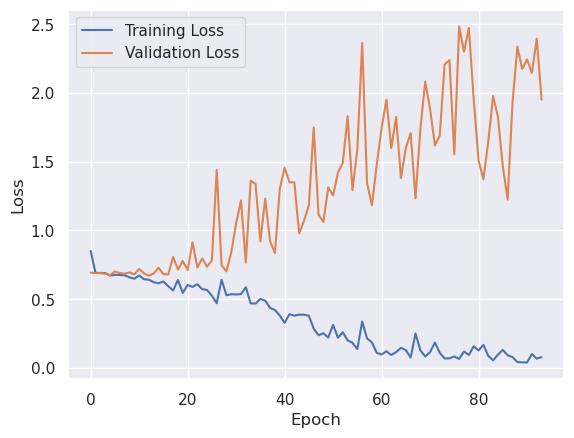

16/16 [==============================] - 1s 63ms/step - loss: 0.0780 - accuracy: 0.9672 - val_loss: 1.9524 - val_accuracy: 0.6042
Epoch 95/100
16/16 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9713

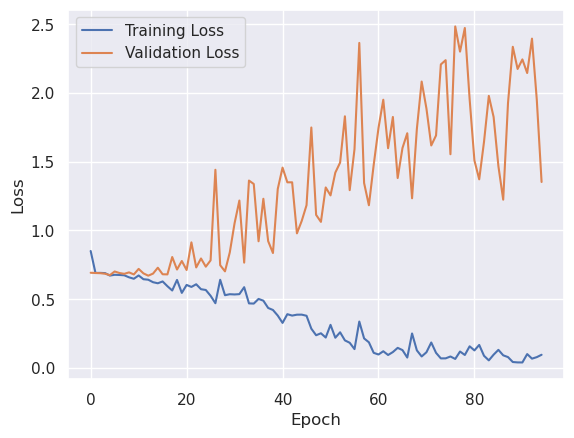

16/16 [==============================] - 1s 63ms/step - loss: 0.0953 - accuracy: 0.9713 - val_loss: 1.3527 - val_accuracy: 0.7083
Epoch 96/100
16/16 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9918

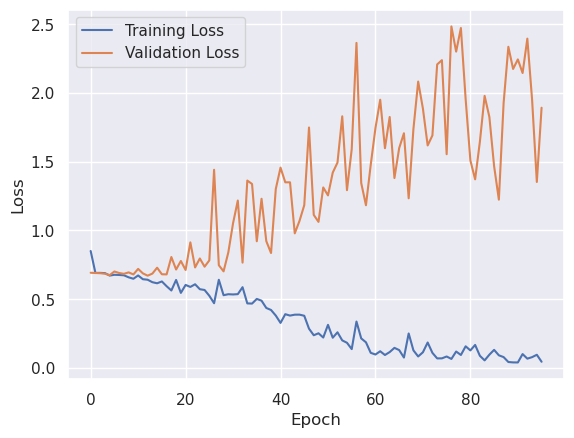

16/16 [==============================] - 1s 62ms/step - loss: 0.0444 - accuracy: 0.9918 - val_loss: 1.8930 - val_accuracy: 0.6667
Epoch 97/100
15/16 [===========================>..] - ETA: 0s - loss: 0.0324 - accuracy: 0.9868

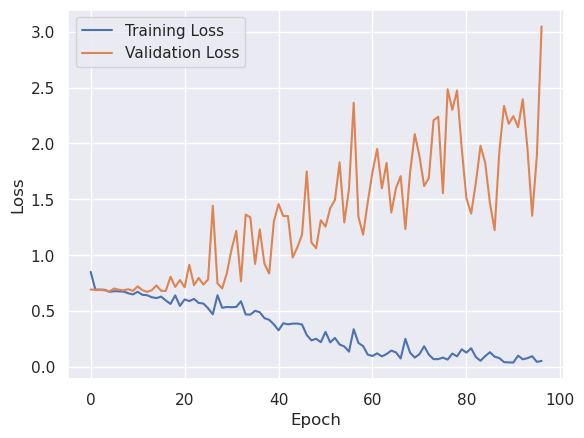

16/16 [==============================] - 1s 64ms/step - loss: 0.0530 - accuracy: 0.9795 - val_loss: 3.0476 - val_accuracy: 0.6042
Epoch 98/100
16/16 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9467

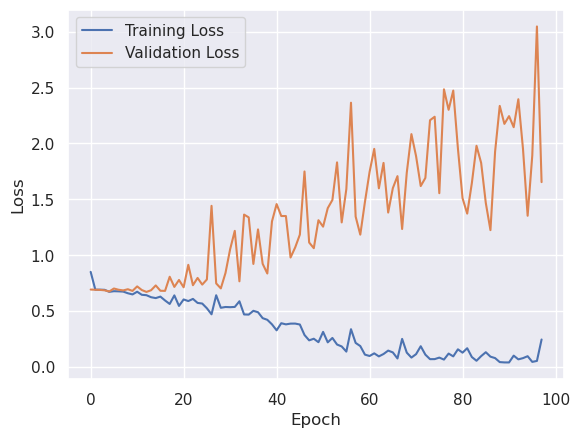

16/16 [==============================] - 1s 63ms/step - loss: 0.2448 - accuracy: 0.9467 - val_loss: 1.6539 - val_accuracy: 0.6562
Epoch 99/100
16/16 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9344

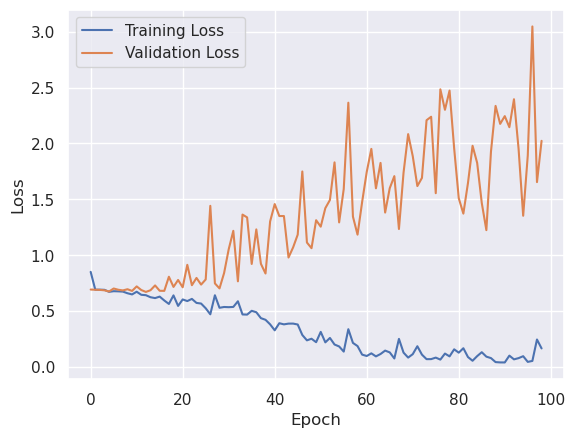

16/16 [==============================] - 1s 63ms/step - loss: 0.1649 - accuracy: 0.9344 - val_loss: 2.0236 - val_accuracy: 0.6250
Epoch 100/100
15/16 [===========================>..] - ETA: 0s - loss: 0.1692 - accuracy: 0.9375

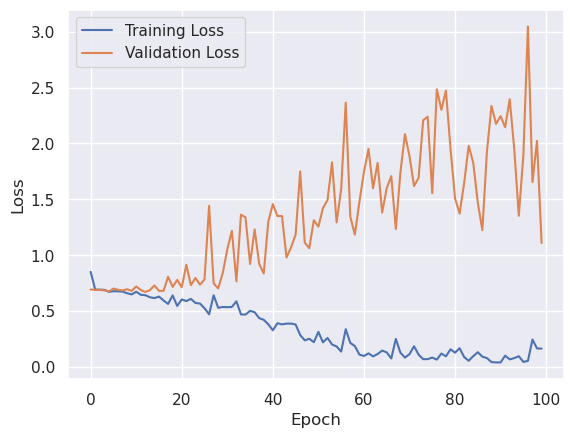

16/16 [==============================] - 1s 65ms/step - loss: 0.1635 - accuracy: 0.9375 - val_loss: 1.1090 - val_accuracy: 0.7083


In [7]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    callbacks=[PlotLossCallback()])

In [ ]:
model.save('dd_model.h5')   



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
test_dir = 'data/original_dataset/test'

test_datagen = ImageDataGenerator(
            rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
        )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(X_RES, Y_RES),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
)

#test_loss, test_accuracy = model.evaluate(test_generator)


# Get the predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate the true positives and false negatives
tp = cm[1][1]
fn = cm[1][0]

# Calculate the recall
recall = tp / (tp + fn)


# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()









In [ ]:
def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(X_RES, Y_RES))
    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions

In [ ]:
#model = keras.models.load_model('dd_model.h5')


In [ ]:
import  pandas as pd
from IPython.display import display

dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'
i = 0
prediction_results = []
for file_name in os.listdir(dir_path):
    
    predictions = predict(model, dir_path+file_name)
    
    dp, fn = os.path.split(dir_path)
    prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
    i = i + 1
    if i == 100:
        break

df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])
display(df)